# PtyLab.py demo
In this short tutorial we will simulate a conventional ptychography experiment. To simulate a ptychography experiment the following steps have to be performed.

1. The geometry of the experiment needs to be specified. The following variables need to be defined.
    - Wavelength of the illuminating beam
    - Sample to detector distance (z0)
    - Detector pixel number (Nd)
    - Detector pixel size (dxd)
2. The illuminating beam (which we refer to as probe) has to be defined 
3. The object to be simulated needs to be defined
4. The scan grid, i.e. the coordinates with which the object is scanned, must be generated.
5. For each position a diffraction pattern needs to be calculated.

Finally, at the end of this tutorial, the object is reconstructed from the created diffraction images.

## 0. Installation

Installing the dependencies of `ptylab`

In [ ]:
%pip install git+https://github.com/PtyLab/PtyLab.py.git

## 1. Geometry of the experiment

First we need to import all necessary packages.

In [1]:
# First all required modules must be imported
import numpy as np
from PtyLab.utils.utils import circ, gaussian2D, cart2pol
from PtyLab.utils.scanGrids import GenerateNonUniformFermat
from PtyLab.Operators.Operators import aspw
from PtyLab.utils.visualisation import hsvplot, absplot, show3Dslider
import matplotlib.pylab as plt
from scipy.signal import convolve2d

In the next step we define the geometry of the experiment and calculate the grids in the sample and detector plane. The geometry of the experiment for a standard conventional ptychography experiment is defined by three parameter:

1. The wavelength of the illuminating beam, which we assume here to be 632.8 nm
2. The distance between the sample and the detector (which we name zo)
3. The shape (Nd) and pixelsize (dxd) of the detector

In [2]:
# Set the geometry of the Experiment
wavelength = 632.8e-9
zo = 5e-2
Nd = 2**7
dxd = 16 * 4.5e-6

# Calculate the length of the detector
Ld = Nd * dxd

# probe coordinates
dxp = wavelength * zo / Ld
Np = Nd
Lp = dxp * Np
xp = np.arange(-Np // 2, Np // 2) * dxp
Xp, Yp = np.meshgrid(xp, xp)

# object coordinates
No = 2**9
dxo = dxp
Lo = dxo * No
xo = np.arange(-No // 2, No // 2) * dxo
Xo, Yo = np.meshgrid(xo, xo)

## 2. Definition of the illuminating beam
In the next step we define the beam (probe), which we want to use for our simulation. Here, a pinhole is simulated which is convolved with a gaussian kernel.

In [3]:
# generate illumination
# note: simulate focused beam
# goal: 1:1 image iris through (low-NA) lens with focal length f onto an object
f = 5e-3  # focal length of lens, creating a focused probe
pinhole = circ(Xp, Yp, Lp / 2)
pinhole = convolve2d(pinhole, gaussian2D(5, 1).astype(np.float32), mode="same")

Next, we propagate probe on the sample using a propagator and use the matplotlib to plot the probe.

Text(0.5, 1.0, 'probe intensity')

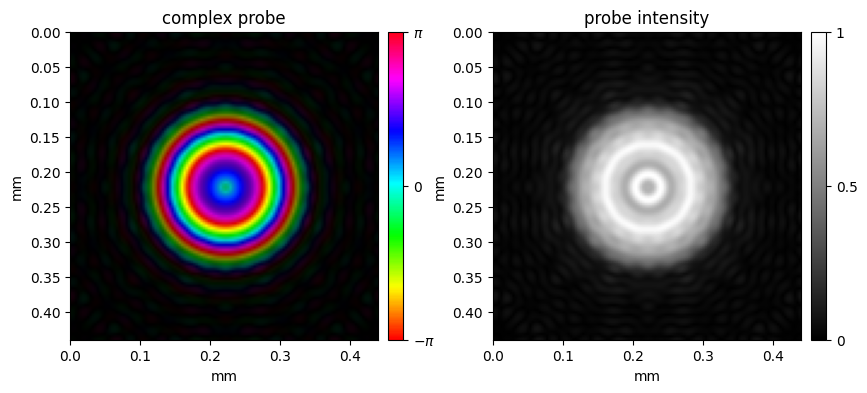

In [4]:
# propagate to lens
probe = aspw(pinhole, 2 * f, wavelength, Lp, is_FT=False)[0]

# multiply with quadratic phase and aperture
aperture = circ(Xp, Yp, 3 * Lp / 4)
aperture = convolve2d(aperture, gaussian2D(5, 3).astype(np.float32), mode="same")
probe = (
    probe
    * np.exp(-1.0j * 2 * np.pi / wavelength * (Xp**2 + Yp**2) / (2 * f))
    * aperture
)
probe = aspw(probe, 2 * f, wavelength, Lp, is_FT=False)[0]

plt.figure(figsize=(10, 4), num=1)
ax1 = plt.subplot(121)
hsvplot(probe, ax=ax1, pixelSize=dxp, axisUnit="mm")
ax1.set_title("complex probe")
ax2 = plt.subplot(122)
absplot(abs(probe), ax=ax2, pixelSize=dxp, axisUnit="mm", cmap="gray")
ax2.set_title("probe intensity")
# plt.show(block=False)

## 3. Definition of an object
In this example we define a binary spiral as a test object. The object needs to have a larger array size than the probe, since the probe is scanned over the object.

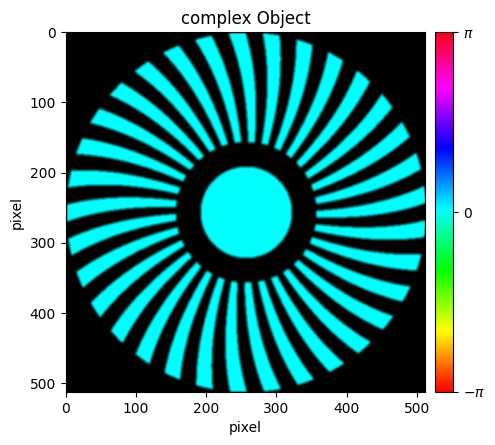

In [5]:
# generate object
d = 1e-3  # the smaller this parameter the larger the spatial frequencies in the simulated object
b = 33  # topological charge (feel free to play with this number)
theta, rho = cart2pol(Xo, Yo)
t = (1 + np.sign(np.sin(b * theta + 2 * np.pi * (rho / d) ** 2))) / 2
t = t * circ(Xo, Yo, Lo) * (1 - circ(Xo, Yo, 200 * dxo)) + circ(Xo, Yo, 130 * dxo)
obj = convolve2d(t, gaussian2D(5, 3), mode="same")  # smooth edges

plt.figure(figsize=(5, 5))
ax = plt.axes()
hsvplot(np.squeeze(obj), ax=ax)
ax.set_title("complex Object")
plt.show(block=False)

## 4. Definition of the scan map
In the next step we create a scan grid with 100 points. For this purpose, we use a ptyLab internal function that generates a grid in which the scan points are distributed as homogeneously as possible (Fermat's spiral).

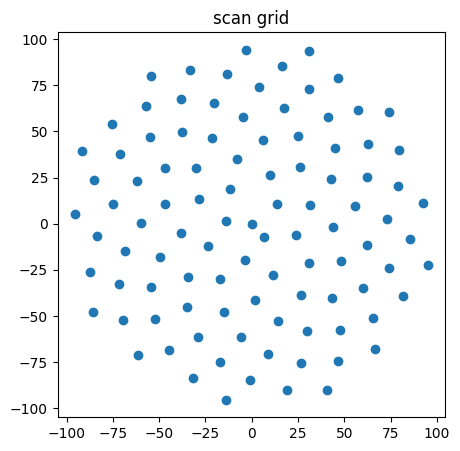

In [6]:
numPoints = 100  # number of points
radius = 100  # radius of final scan grid (in pixels)
p = 1  # p = 1 is standard Fermat;  p > 1 yields more points towards the center of grid
y_coord, x_coord = GenerateNonUniformFermat(numPoints, radius=radius, power=p)

# show scan grid
plt.figure(figsize=(5, 5))
plt.plot(y_coord, x_coord, "o")
plt.title("scan grid")
plt.show(block=False)

In the next step we calculate the physical coordinates (in meters) and save them together in a single array, which we call encoder. The scan positions are plotted for illustration on the simulated object.

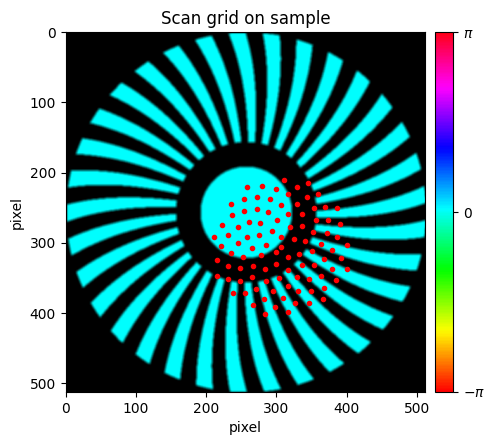

In [7]:
# Calculate
encoder = np.vstack((y_coord * dxo, x_coord * dxo)).T

# prevent negative indices by centering spiral coordinates on object
positions = np.round(encoder / dxo)
offset = 50
positions = (positions + No // 2 - Np // 2 + offset).astype(int)

# get number of positions
numFrames = len(x_coord)

# show scan grid on object
plt.figure(figsize=(5, 5))
ax1 = plt.axes()
hsvplot(np.squeeze(obj), ax=ax1)
ax1.plot(positions[:, 1] + Np // 2, positions[:, 0] + Np // 2, ".", c="red")
ax1.set_title("Scan grid on sample")
plt.show(block=False)

## 5. Calculate diffraction data
Finally we have all the information to calculate the diffraction patterns. For this purpose we create a 3-dimensionale array, which is used to store for each position the diffraction data. We name this array ptychogram. 

In [8]:
# generate the ptychogram array
ptychogram = np.zeros((numFrames, Nd, Nd))

In the next step, we iterate through all the calculated positions and slice the object according to the size of the probe-array. The slice is named object patch. Since the object patch has the same size as the sample, the exit-surface-wave (esw) can be calculated in the next step. The esw represents the electric field directly behind the sample. Thus, the electric field in the detector plane can be calculated by the Fourier transform of the esw. Here it is assumed that the far field approximation is valid. 

In [9]:
for loop in np.arange(numFrames):
    # get object patch
    row, col = positions[loop]
    sy = slice(row, row + Np)
    sx = slice(col, col + Np)
    # note that object patch has size of probe array
    objectPatch = obj[..., sy, sx].copy()
    # multiply each probe mode with object patch
    esw = objectPatch * probe
    # generate diffraction data, propagate the esw to the detector plane
    ESW = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(esw), norm="ortho"))
    # save data in ptychogram
    ptychogram[loop] = abs(ESW) ** 2

Next the ptychogram is plotted using a ptyLab plotting function.

In [10]:
# Show the calculated diffraction data on an interactive gui backend such as qt
# show3Dslider(np.log(ptychogram))

## 6. Reconstruction of the simulated data

Finally, the object is reconstructed from the generated diffraction data. For this purpose, a ptyLab reconstruction script was prepared. The script starts the reconstruction process and therefore retrieves the object and probe. The structure and functionality of the reconstruction script will be explained in the next tutorial.   

In [11]:
from PtyLab import ExperimentalData
from PtyLab import Reconstruction
from PtyLab import Monitor
from PtyLab import Params
from PtyLab import Engines
import matplotlib as mpl

# uncomment below for showing reconstructions with interactive qt backend instead of inline
# mpl.use("qt5Agg")

In [12]:
## initialize the ExperimentalData class and set values
exampleData = ExperimentalData(operationMode="CPM")

# check the requiredFields and the optionalFields of the ExperimentalData class
print(exampleData.requiredFields)
print(exampleData.optionalFields)

['ptychogram', 'wavelength', 'encoder', 'dxd', 'zo']
['entrancePupilDiameter', 'spectralDensity', 'theta', 'emptyBeam']


In [13]:
# fill up the requiredFields
exampleData.ptychogram = ptychogram
exampleData.wavelength = wavelength
exampleData.encoder = encoder
exampleData.dxd = dxd
exampleData.zo = zo
# then fill up optionalFields. If not used, set the values to None
exampleData.entrancePupilDiameter = 150e-6  # initial estimate of beam diameter
exampleData.spectralDensity = None  # used in polychromatic ptychography
exampleData.theta = None  # used in tiltPlane reflection ptychography

# call _setData to auto-calculate all the necessary variables in ExperimentalData
exampleData._setData()

In [14]:
## initialize the Monitor class and set values
monitor = Monitor()
monitor.figureUpdateFrequency = 5
monitor.objectPlot = "complex"  # complex abs angle
monitor.verboseLevel = "low"  # high: plot two figures, low: plot only one figure
monitor.objectZoom = 1.5  # control object plot FoV
monitor.probeZoom = 0.5  # control probe plot FoV

In [15]:
## initialize the Params class and set values
params = Params()
# main parameters
params.positionOrder = "random"  # 'sequential' or 'random'
params.propagator = (
    "Fresnel"  # Fraunhofer Fresnel ASP scaledASP polychromeASP scaledPolychromeASP
)
params.intensityConstraint = "standard"  # standard fluctuation exponential poission
# how do we want to reconstruct (all Switches are set to False by default)
params.gpuSwitch = False
params.probePowerCorrectionSwitch = True
params.modulusEnforcedProbeSwitch = False
params.comStabilizationSwitch = True
params.orthogonalizationSwitch = False
params.orthogonalizationFrequency = 10
params.fftshiftSwitch = False

INFO:GPU:cupy is unavailable, switching to CPU


In [16]:
## initialize the Reconstruction class and set values
reconstruction = Reconstruction(exampleData, params)
reconstruction.npsm = 1  # Number of probe modes to reconstruct
reconstruction.nosm = 1  # Number of object modes to reconstruct
reconstruction.nlambda = 1  # len(exampleData.spectralDensity) # Number of wavelength
reconstruction.nslice = 1  # Number of object slice

reconstruction.initialProbe = "circ"
reconstruction.initialObject = "ones"

# initialize probe and object
reconstruction.initializeObjectProbe()
# optional: customize initial probe quadratic phase
reconstruction.probe = reconstruction.probe * np.exp(
    1.0j
    * 2
    * np.pi
    / reconstruction.wavelength
    * (reconstruction.Xp**2 + reconstruction.Yp**2)
    / (2 * 6e-3)
)

INFO:Reconstruction:Copying attribute wavelength
INFO:Reconstruction:Copying attribute dxd
INFO:Reconstruction:Copying attribute theta
INFO:Reconstruction:Copying attribute spectralDensity
INFO:Reconstruction:Copying attribute entrancePupilDiameter
INFO:Reconstruction:Initial object set to ones
INFO:Reconstruction:Initial probe set to circ


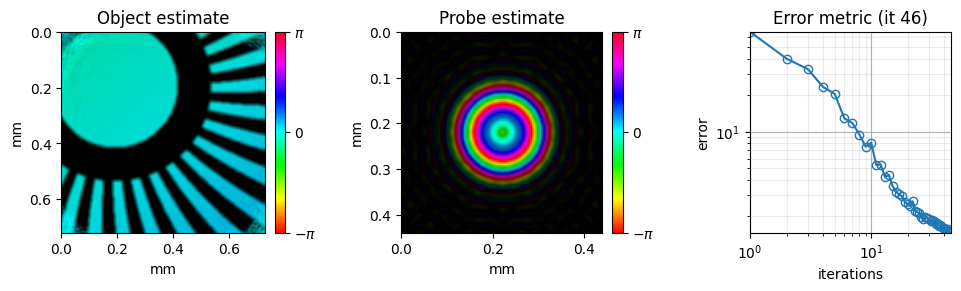

INFO:mPIE:Doing probe com stabilization


mPIE:  94%|█████████▍| 47/50 [00:04<00:00,  9.57it/s]

INFO:mPIE:Doing probe com stabilization


INFO:mPIE:Doing probe com stabilization


mPIE:  98%|█████████▊| 49/50 [00:05<00:00, 10.35it/s]

INFO:mPIE:Doing probe com stabilization


mPIE: 100%|██████████| 50/50 [00:05<00:00,  9.58it/s]


In [17]:
# choose the reconstruction engine and set values
engine_mPIE = Engines.mPIE(reconstruction, exampleData, params, monitor)
engine_mPIE.numIterations = 50
engine_mPIE.betaProbe = 0.25
engine_mPIE.betaObject = 0.25
# start reconstruction
engine_mPIE.reconstruct()

plt.close("all")

In [18]:
# reconstruction.saveResults("result.hdf5")